In [1]:
# Change directory level to be 1 level up
import os
def dir_level(num, path):
    if num == 1:
        return os.path.dirname(path)
    else:
        return os.path.dirname(dir_level(num-1,path))

current_dir = os.getcwd()
home_dir = dir_level(1,os.getcwd())
# print(current_dir)    
# print(home_dir)
os.chdir(home_dir)
# print(os.getcwd())

## Download the Datasets that Will be Used

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recordlinkage
from src.api_data_gov import download_collection

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Get the ACRA information which is at collection 2
acra = download_collection(collection_id=2, chk='Yes', combcsv='No',
                           indcsv='Yes', csvdir='data')
print(acra)

Collection 2 contains 27 no(s) of dataset.
Checked 1 out of 27 datasets.
Checked 2 out of 27 datasets.
Checked 3 out of 27 datasets.
Checked 4 out of 27 datasets.
Checked 5 out of 27 datasets.
Checked 6 out of 27 datasets.
Checked 7 out of 27 datasets.
Checked 8 out of 27 datasets.
Checked 9 out of 27 datasets.
Checked 10 out of 27 datasets.
Checked 11 out of 27 datasets.
Checked 12 out of 27 datasets.
Checked 13 out of 27 datasets.
Checked 14 out of 27 datasets.
Checked 15 out of 27 datasets.
Checked 16 out of 27 datasets.
Checked 17 out of 27 datasets.
Checked 18 out of 27 datasets.
Checked 19 out of 27 datasets.
Checked 20 out of 27 datasets.
Checked 21 out of 27 datasets.
Checked 22 out of 27 datasets.
Checked 23 out of 27 datasets.
Checked 24 out of 27 datasets.
Checked 25 out of 27 datasets.
Checked 26 out of 27 datasets.
Checked 27 out of 27 datasets.
All files were downloaded previously.
           _id         uen issuance_agency_id  \
0            1   00012700X               A

In [4]:
acracollist = ['uen','entity_name','postal_code','entity_type_description', 'business_constitution_description',
               'primary_ssic_code','primary_ssic_description','secondary_ssic_code','secondary_ssic_description',
               'entity_status_description','registration_incorporation_date']
acra_df = acra.loc[:, acracollist]

# Clean up the 'na' in the column, and convert the date
acra_df.replace('na', np.nan, inplace=True)
acra_df['registration_incorporation_date'] = pd.to_datetime(acra_df['registration_incorporation_date'], errors='coerce')

# Get total number of months / years since registration
ref_date = pd.Timestamp('2024-03-01')
acra_df['months_live'] = ((ref_date.year-acra_df['registration_incorporation_date'].dt.year)*12+
                          (ref_date.month-acra_df['registration_incorporation_date'].dt.month))
acra_df['years_live'] = ref_date.year-acra_df['registration_incorporation_date'].dt.year
acra_df['year_incorporated'] = acra_df['registration_incorporation_date'].dt.year

# Do binning based on dates
# Define bucket boundaries in years
year_buckets = {
    'Less than 2 years': 2,
    '2 - 5 Years': 5,
    '6 - 10 Years': 10,
    '10 - 20 Years': 20,
    'More than 20 Years': 1000
}

# Categorize the year data into buckets
acra_df['years_bucket'] = pd.cut((ref_date - acra_df['registration_incorporation_date']).dt.days / 365, 
                      bins=[0] + list(year_buckets.values()), 
                      labels=list(year_buckets.keys()), 
                      right=False)

# Categorize entity status into buckets
# 3 buckets of Live, No Status, Others
acra_df['entity_status_bucket'] = acra_df['entity_status_description']
acra_df['entity_status_bucket'] = acra_df['entity_status_bucket'].fillna('No Status')
live_list = ['Live Company', 'Live', 'Live (Receiver or Receiver and Manager appointed)', 'Converted To LLP', 'Amalgamated']
acra_df['entity_status_bucket'] = acra_df['entity_status_bucket'].replace({variation: 'Live' for variation in live_list})
acra_df.loc[~acra_df['entity_status_bucket'].isin(['Live','No Status']), 'entity_status_bucket'] = 'Others'

acra_df['registration_incorporation_date'] = acra_df['registration_incorporation_date'].dt.strftime('%Y-%m-%d')
acra_df = acra_df.add_prefix('acra_')

# Sort the whole dataframe by entity_name alphabetically
acra_df = acra_df.sort_values(by='acra_entity_name', ascending=True)
print(acra_df)

          acra_uen                 acra_entity_name acra_postal_code  \
450242   53278504E                            !3MED           820296   
450604   53311591D                     !DEABUNDANCE           398453   
438517  201542182E  !DEAS CREATIVE STUDIO PTE. LTD.           369977   
442926  202334903D             !NTANGIBLE PTE. LTD.           101070   
445000   52892494W                    !WEB A-GO-GO!           596282   
...            ...                              ...              ...   
444231   51387100D        `THE FLINT HILLS' TRADERS           328958   
453719  T14LL1179L              {FLIPPINGNOTES} LLP           791435   
447890   53121559L                     | S | FACTOR           438795   
446669   53030403A                   ~ISMS PICTURES           141040   
537387   53347159A                              NaN           460003   

       acra_entity_type_description acra_business_constitution_description  \
450242                     Business                      

In [5]:
# Get the Directory of Renovation Contractors from HDB, which is at collection 155
hdb = download_collection(collection_id=155, chk='No', combcsv='No',
                           indcsv='Yes', csvdir='data')
print(hdb)
hdbcollist = ['uen', 'directory_ref_no', 'company_name', 'address', 'postal_code',
              'email_address', 'contact_no']

Collection 155 contains 1 no(s) of dataset.
Start of Dataset 1 out of 1
There are a total of 2624 rows in this dataset
Processed 1000 / 2624 rows.
Processed 2000 / 2624 rows.
Processed 2624 / 2624 rows.
data/2024-02-08 Renovation Contractors who can carry out Renovation works by Company Name.csv downloaded
data/2024-02-08 Renovation Contractors who can carry out Renovation works by Company Name_dtype.json created
End of Dataset 1 out of 1
       _id          uen directory_ref_no  \
0        1   28713000B      HB-01-0014E    
1        2   37111300L      HB-01-0022B    
2        3   35198200X      HB-01-0028A    
3        4   35627700C      HB-01-0030G    
4        5  201209970W      HB-01-0031B    
...    ...          ...              ...   
2619  2620  201815259D      HB-12-6104D    
2620  2621   53421905E      HB-12-6105G    
2621  2622  200911508E      HB-12-6106B    
2622  2623  202029040D      HB-12-6107E    
2623  2624  201503589D      HB-12-6108H    

                            

In [6]:
hdbcollist = ['uen', 'directory_ref_no', 'company_name', 'address', 'postal_code',
              'email_address', 'contact_no']
hdb_df = hdb.loc[:, hdbcollist]

# HDB columns all have some space in the middle. to strip it off.
for x in hdbcollist:
    hdb_df[x] = hdb_df[x].str.strip()

hdb_df = hdb_df.add_prefix('hdb_')
print(hdb_df)

         hdb_uen hdb_directory_ref_no  \
0      28713000B          HB-01-0014E   
1      37111300L          HB-01-0022B   
2      35198200X          HB-01-0028A   
3      35627700C          HB-01-0030G   
4     201209970W          HB-01-0031B   
...          ...                  ...   
2619  201815259D          HB-12-6104D   
2620   53421905E          HB-12-6105G   
2621  200911508E          HB-12-6106B   
2622  202029040D          HB-12-6107E   
2623  201503589D          HB-12-6108H   

                                       hdb_company_name  \
0                                 CHUAN TONG TRADING CO   
1     CHIAT CHEE RENOVATION CONSTRUCTION & CLEANING ...   
2                     CHYE LING HIN BUILDING CONTRACTOR   
3                   AROWANA RENOVATION & INTERIOR DECOR   
4                                  3 E DESIGN PTE. LTD.   
...                                                 ...   
2619                                 CLESTRAT PTE. LTD.   
2620                               

In [7]:
print(hdb_df[hdb_df['hdb_uen']=='201503589D'])

         hdb_uen hdb_directory_ref_no       hdb_company_name  \
2623  201503589D          HB-12-6108H  TSM PROJECT PTE. LTD.   

                                      hdb_address hdb_postal_code  \
2623  BLK 7  #05-36 MANDAI LINK MANDAI CONNECTION          728653   

              hdb_email_address hdb_contact_no  
2623  WUIMENG.NG@TSMCONS.COM.SG       63583936  


In [8]:
# Get the Listing of Registered Contractors from BCA, which is at collection 16
bca = download_collection(collection_id=16, chk='No', combcsv='No',
                           indcsv='Yes', csvdir='data')
print(bca)


Collection 16 contains 1 no(s) of dataset.
Start of Dataset 1 out of 1
There are a total of 19288 rows in this dataset
Processed 1000 / 19288 rows.
Processed 2000 / 19288 rows.
Processed 3000 / 19288 rows.
Processed 4000 / 19288 rows.
Processed 5000 / 19288 rows.
Processed 6000 / 19288 rows.
Processed 7000 / 19288 rows.
Processed 8000 / 19288 rows.
Processed 9000 / 19288 rows.
Processed 10000 / 19288 rows.
Processed 11000 / 19288 rows.
Processed 12000 / 19288 rows.
Processed 13000 / 19288 rows.
Processed 14000 / 19288 rows.
Processed 15000 / 19288 rows.
Processed 16000 / 19288 rows.
Processed 17000 / 19288 rows.
Processed 18000 / 19288 rows.
Processed 19000 / 19288 rows.
Processed 19288 / 19288 rows.
data/2024-01-31 Listing of Registered Contractors.csv downloaded
data/2024-01-31 Listing of Registered Contractors_dtype.json created
End of Dataset 1 out of 1
         _id                            company_name      uen_no workhead  \
0          1                #1 DESIGN STUDIO PTE LTD 

In [9]:
bcacollist = ['company_name', 'uen_no', 'workhead', 'grade', 'additional_info', 'expiry_date',
              'building_no', 'street_name', 'unit_no', 'building_name', 'postal_code', 'tel_no']
bca_df = bca.loc[:, bcacollist]
bca_df = bca_df.add_prefix('bca_')
print(bca_df)

                             bca_company_name  bca_uen_no bca_workhead  \
0                    #1 DESIGN STUDIO PTE LTD  201925566H         FM02   
1      'A' BUILDERS AND ENGINEERING PTE. LTD.  202320660Z         CR06   
2                   @BSOLUTE AIRCON PTE. LTD.  201326611Z         ME01   
3                           1 CHUAN PTE. LTD.  200610983D         CR18   
4                      1 PLUS PRIVATE LIMITED  201626670R         FM02   
...                                       ...         ...          ...   
19283                       ZTHRONE PTE. LTD.  202215785N         CR01   
19284               ZTS CONSTRUCTION PTE.LTD.  201725383E         CR01   
19285                  ZULIN (S.E.A.)PTE.LTD.  201206076D         SY10   
19286       ZULU ENGINEERING SERVICES PTE LTD  201714402M         ME01   
19287       ZULU ENGINEERING SERVICES PTE LTD  201714402M         ME05   

          bca_grade bca_additional_info bca_expiry_date bca_building_no  \
0                L1                 

In [10]:
# Additional info sourced from outside of data.gov.sg
# Compiled by myself after going thru all the pdf documents
bca_wh_fp = str(os.getcwd()) + '\own_datasets\workhead_consolidated.csv'
bca_wh = pd.read_csv(bca_wh_fp)
print(bca_wh)

    workhead         grade         workhead_type  \
0       CR01  Single Grade  Construction-Related   
1       CR02            L1  Construction-Related   
2       CR02            L2  Construction-Related   
3       CR02            L3  Construction-Related   
4       CR02            L5  Construction-Related   
..       ...           ...                   ...   
279     TR06  Single Grade            Trade Head   
280     TR07  Single Grade            Trade Head   
281     TR08  Single Grade            Trade Head   
282     TR09  Single Grade            Trade Head   
283     TR10  Single Grade            Trade Head   

                               workhead_title  grade_financial_sgd  \
0                    Minor Construction Works                10000   
1                        Corrosion Protection                10000   
2                        Corrosion Protection                50000   
3                        Corrosion Protection               150000   
4                        

In [11]:
bca_wh_df = bca_wh.add_prefix('bcawh_')
print(bca_wh_df)

    bcawh_workhead   bcawh_grade   bcawh_workhead_type  \
0             CR01  Single Grade  Construction-Related   
1             CR02            L1  Construction-Related   
2             CR02            L2  Construction-Related   
3             CR02            L3  Construction-Related   
4             CR02            L5  Construction-Related   
..             ...           ...                   ...   
279           TR06  Single Grade            Trade Head   
280           TR07  Single Grade            Trade Head   
281           TR08  Single Grade            Trade Head   
282           TR09  Single Grade            Trade Head   
283           TR10  Single Grade            Trade Head   

                         bcawh_workhead_title  bcawh_grade_financial_sgd  \
0                    Minor Construction Works                      10000   
1                        Corrosion Protection                      10000   
2                        Corrosion Protection                      50000   

## Combine the Datasets

In [12]:
# Combine bca_wh info into bca to become bca_2
bca_2 = pd.merge(bca_df, bca_wh_df, how='left', left_on=['bca_workhead','bca_grade'],
                    right_on=['bcawh_workhead','bcawh_grade'])
print(bca_2)

                             bca_company_name  bca_uen_no bca_workhead  \
0                    #1 DESIGN STUDIO PTE LTD  201925566H         FM02   
1      'A' BUILDERS AND ENGINEERING PTE. LTD.  202320660Z         CR06   
2                   @BSOLUTE AIRCON PTE. LTD.  201326611Z         ME01   
3                           1 CHUAN PTE. LTD.  200610983D         CR18   
4                      1 PLUS PRIVATE LIMITED  201626670R         FM02   
...                                       ...         ...          ...   
19283                       ZTHRONE PTE. LTD.  202215785N         CR01   
19284               ZTS CONSTRUCTION PTE.LTD.  201725383E         CR01   
19285                  ZULIN (S.E.A.)PTE.LTD.  201206076D         SY10   
19286       ZULU ENGINEERING SERVICES PTE LTD  201714402M         ME01   
19287       ZULU ENGINEERING SERVICES PTE LTD  201714402M         ME05   

          bca_grade bca_additional_info bca_expiry_date bca_building_no  \
0                L1                 

In [13]:
print(bca_2[bca_2['bca_uen_no']=='201503589D'])

          bca_company_name  bca_uen_no bca_workhead     bca_grade  \
17277  TSM PROJECT PTE LTD  201503589D         CR03  Single Grade   

      bca_additional_info bca_expiry_date bca_building_no bca_street_name  \
17277                  na      01/10/2026               7     MANDAI LINK   

      bca_unit_no  bca_building_name bca_postal_code bca_tel_no  \
17277      #05-36  MANDAI CONNECTION          728653   81139853   

      bcawh_workhead   bcawh_grade   bcawh_workhead_type bcawh_workhead_title  \
17277           CR03  Single Grade  Construction-Related           Demolition   

       bcawh_grade_financial_sgd  bcawh_track_record_sgd  \
17277                      10000                  100000   

       bcawh_paid_up_capital_sgd  bcawh_version  
17277                          0           2022  


In [14]:
# Combine acra into hdb to become hdb_2
hdb_2 = pd.merge(hdb_df, acra_df, how='left', left_on=['hdb_uen'],
                    right_on=['acra_uen'])
print(hdb_2)

         hdb_uen hdb_directory_ref_no  \
0      28713000B          HB-01-0014E   
1      37111300L          HB-01-0022B   
2      35198200X          HB-01-0028A   
3      35627700C          HB-01-0030G   
4     201209970W          HB-01-0031B   
...          ...                  ...   
2619  201815259D          HB-12-6104D   
2620   53421905E          HB-12-6105G   
2621  200911508E          HB-12-6106B   
2622  202029040D          HB-12-6107E   
2623  201503589D          HB-12-6108H   

                                       hdb_company_name  \
0                                 CHUAN TONG TRADING CO   
1     CHIAT CHEE RENOVATION CONSTRUCTION & CLEANING ...   
2                     CHYE LING HIN BUILDING CONTRACTOR   
3                   AROWANA RENOVATION & INTERIOR DECOR   
4                                  3 E DESIGN PTE. LTD.   
...                                                 ...   
2619                                 CLESTRAT PTE. LTD.   
2620                               

### There were some HDB uen that was not able to match with ACRA uen

In [15]:
# Check for HDB uen that was not able to match with ACRA uen
empty_uen = hdb_2[hdb_2['acra_uen'].isna()]
print(empty_uen)
print(empty_uen.index)

         hdb_uen hdb_directory_ref_no  \
241   200416909E          HB-02-0431F   
313   200010488N          HB-02-3815F   
1169  199796743M          HB-06-3250A   
1175  200010842B          HB-06-3379B   

                               hdb_company_name  \
241   GREAT OASIS ASIAN TRADING COMPANY PTE LTD   
313           LIANG WOOD DESIGN & BUILD PTE LTD   
1169                 CROWN CONSTRUCTION PTE LTD   
1175           THE CARPENTER'S WORKSHOP PTE LTD   

                                     hdb_address hdb_postal_code  \
241   BLK 55  #05-03 SERANGOON NORTH AVENUE 4 S9          555859   
313                     BLK 6  #07-21 Gambas Way          756939   
1169                           BLK 55 Loyang Way          508748   
1175                      BLK 477 JOO CHIAT ROAD          427683   

                   hdb_email_address hdb_contact_no acra_uen acra_entity_name  \
241           INFO@GREATOASIS.COM.SG       62583233      NaN              NaN   
313          LIANGWIR@SINGNET.COM.S

#### Use RecordLinkage Sorted Neighbourhood indexing method to index the company_name and entity_name.
#### Then compare the UEN for similar uen

In [16]:
# SN with company_name and entity_name, comparing uen
indexer = recordlinkage.Index()
indexer.sortedneighbourhood('hdb_company_name','acra_entity_name')
candidate_links = indexer.index(empty_uen, acra_df)
compare_cl = recordlinkage.Compare()
compare_cl.string('hdb_uen', 'acra_uen', method='jarowinkler', threshold=0.9)
features = compare_cl.compute(candidate_links, empty_uen, acra_df).sort_index(level=0)
matches = features[features.sum(axis=1) >= 1].sort_index(level=0)
print(features)
print(matches)
print(matches.index)

                0
241  1696053  1.0
     1726439  0.0
313  828552   1.0
     842032   0.0
     865659   0.0
1169 547850   0.0
     556216   1.0
     639880   0.0
1175 1507199  1.0
     1575230  0.0
     1582230  0.0
                0
241  1696053  1.0
313  828552   1.0
1169 556216   1.0
1175 1507199  1.0
MultiIndex([( 241, 1696053),
            ( 313,  828552),
            (1169,  556216),
            (1175, 1507199)],
           )


In [17]:
# Ensure the result is a 1 to 1 mapping.
dict_map = {}
extra_idx = []
for ori_idx, match_idx in matches.index:
    if ori_idx not in dict_map.keys():
        dict_map[ori_idx] = match_idx
    else:
        extra_idx.append((ori_idx, match_idx))
print(dict_map)
if len(extra_idx) == 0:
    orilist = []
    matchlist = []
    for ori_idx, match_idx in dict_map.items():
        orilist.append(ori_idx)
        matchlist.append(match_idx)
    new_ori = hdb_df.loc[orilist]
    new_match = acra_df.loc[matchlist]
    new_match.index = new_ori.index
    hdb_2_to_add = pd.concat([new_ori,new_match], axis=1)   # Concat in the column
    print(hdb_2_to_add)

{241: 1696053, 313: 828552, 1169: 556216, 1175: 1507199}
         hdb_uen hdb_directory_ref_no  \
241   200416909E          HB-02-0431F   
313   200010488N          HB-02-3815F   
1169  199796743M          HB-06-3250A   
1175  200010842B          HB-06-3379B   

                               hdb_company_name  \
241   GREAT OASIS ASIAN TRADING COMPANY PTE LTD   
313           LIANG WOOD DESIGN & BUILD PTE LTD   
1169                 CROWN CONSTRUCTION PTE LTD   
1175           THE CARPENTER'S WORKSHOP PTE LTD   

                                     hdb_address hdb_postal_code  \
241   BLK 55  #05-03 SERANGOON NORTH AVENUE 4 S9          555859   
313                     BLK 6  #07-21 Gambas Way          756939   
1169                           BLK 55 Loyang Way          508748   
1175                      BLK 477 JOO CHIAT ROAD          427683   

                   hdb_email_address hdb_contact_no    acra_uen  \
241           INFO@GREATOASIS.COM.SG       62583233  200416906E   
313   

In [18]:
# Remove na from hdb_2 dataset and add in the new dataset.
hdb_2_removed_na = hdb_2[~hdb_2['acra_uen'].isna()]
hdb_2_new = pd.concat([hdb_2_removed_na, hdb_2_to_add], axis=0)   # concat in the row.
print(hdb_2_new)

         hdb_uen hdb_directory_ref_no  \
0      28713000B          HB-01-0014E   
1      37111300L          HB-01-0022B   
2      35198200X          HB-01-0028A   
3      35627700C          HB-01-0030G   
4     201209970W          HB-01-0031B   
...          ...                  ...   
2623  201503589D          HB-12-6108H   
241   200416909E          HB-02-0431F   
313   200010488N          HB-02-3815F   
1169  199796743M          HB-06-3250A   
1175  200010842B          HB-06-3379B   

                                       hdb_company_name  \
0                                 CHUAN TONG TRADING CO   
1     CHIAT CHEE RENOVATION CONSTRUCTION & CLEANING ...   
2                     CHYE LING HIN BUILDING CONTRACTOR   
3                   AROWANA RENOVATION & INTERIOR DECOR   
4                                  3 E DESIGN PTE. LTD.   
...                                                 ...   
2623                              TSM PROJECT PTE. LTD.   
241           GREAT OASIS ASIAN TRA

In [19]:
# Combine acra into hdb to become hdb_2
hdb_3 = pd.merge(hdb_2_new, bca_2, how='left', left_on=['hdb_uen'],
                    right_on=['bca_uen_no'])
hdb_3['acra_months_live'] = hdb_3['acra_months_live'].astype(int)
hdb_3['acra_years_live'] = hdb_3['acra_years_live'].astype(int)
hdb_3['acra_year_incorporated'] = hdb_3['acra_year_incorporated'].astype(int)
print(hdb_3)

         hdb_uen hdb_directory_ref_no  \
0      28713000B          HB-01-0014E   
1      37111300L          HB-01-0022B   
2      35198200X          HB-01-0028A   
3      35627700C          HB-01-0030G   
4     201209970W          HB-01-0031B   
...          ...                  ...   
3081  201503589D          HB-12-6108H   
3082  200416909E          HB-02-0431F   
3083  200010488N          HB-02-3815F   
3084  199796743M          HB-06-3250A   
3085  200010842B          HB-06-3379B   

                                       hdb_company_name  \
0                                 CHUAN TONG TRADING CO   
1     CHIAT CHEE RENOVATION CONSTRUCTION & CLEANING ...   
2                     CHYE LING HIN BUILDING CONTRACTOR   
3                   AROWANA RENOVATION & INTERIOR DECOR   
4                                  3 E DESIGN PTE. LTD.   
...                                                 ...   
3081                              TSM PROJECT PTE. LTD.   
3082          GREAT OASIS ASIAN TRA

# HDB DRC Years Live

In [20]:
distinct_hdb_3 = hdb_3.drop_duplicates(subset='hdb_uen')
stacked_data = distinct_hdb_3.groupby(['acra_year_incorporated', 'acra_entity_status_bucket']).size().unstack(fill_value=0)
print(stacked_data)

print()
stacked_data_filtered = stacked_data[stacked_data.index >= 1990].sort_index(ascending=False)
new_stacked_data = stacked_data_filtered.copy()
new_stacked_data['Total'] = new_stacked_data['Live'] + new_stacked_data['No Status'] + new_stacked_data['Others']
new_stacked_data['Not Live %'] = 100 - (new_stacked_data['Live'] / new_stacked_data['Total'] * 100)
print(new_stacked_data)

acra_entity_status_bucket  Live  No Status  Others
acra_year_incorporated                            
1962                          1          0       0
1972                          1          0       0
1974                          7          0       0
1975                         22          0       0
1976                         12          0       0
1977                          7          0       1
1978                         12          0       1
1979                         12          1       2
1980                         16          1       0
1981                         15          0       0
1982                         13          0       0
1983                         31          0       1
1984                         40          2       1
1985                         32          0       0
1986                         27          0       2
1987                         33          0       2
1988                         24          0       0
1989                         20

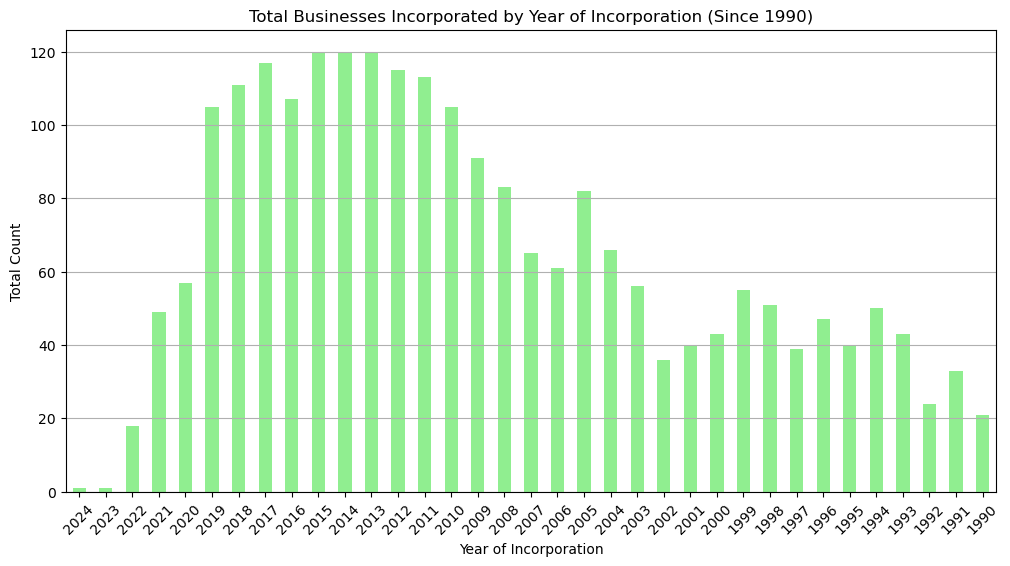

In [21]:
# Plotting the total counts for each year of incorporation
plt.figure(figsize=(12, 6))
new_stacked_data['Total'].plot(kind='bar', color='lightgreen')
plt.title('Total Businesses Incorporated by Year of Incorporation (Since 1990)')
plt.xlabel('Year of Incorporation')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [22]:
stacked_data = distinct_hdb_3.groupby(['acra_years_bucket', 'acra_entity_status_bucket']).size().unstack(fill_value=0)
print(stacked_data)

print()

new_stacked_data = stacked_data.copy()
new_stacked_data['Total'] = new_stacked_data['Live'] + new_stacked_data['No Status'] + new_stacked_data['Others']
new_stacked_data['Not Live %'] = 100 - (new_stacked_data['Live'] / new_stacked_data['Total'] * 100)
print(new_stacked_data)

acra_entity_status_bucket  Live  No Status  Others
acra_years_bucket                                 
Less than 2 years            17          0       0
2 - 5 Years                 191          0       2
6 - 10 Years                571          0       2
10 - 20 Years               905          1       9
More than 20 Years          900          7      19

acra_entity_status_bucket  Live  No Status  Others  Total  Not Live %
acra_years_bucket                                                    
Less than 2 years            17          0       0     17    0.000000
2 - 5 Years                 191          0       2    193    1.036269
6 - 10 Years                571          0       2    573    0.349040
10 - 20 Years               905          1       9    915    1.092896
More than 20 Years          900          7      19    926    2.807775


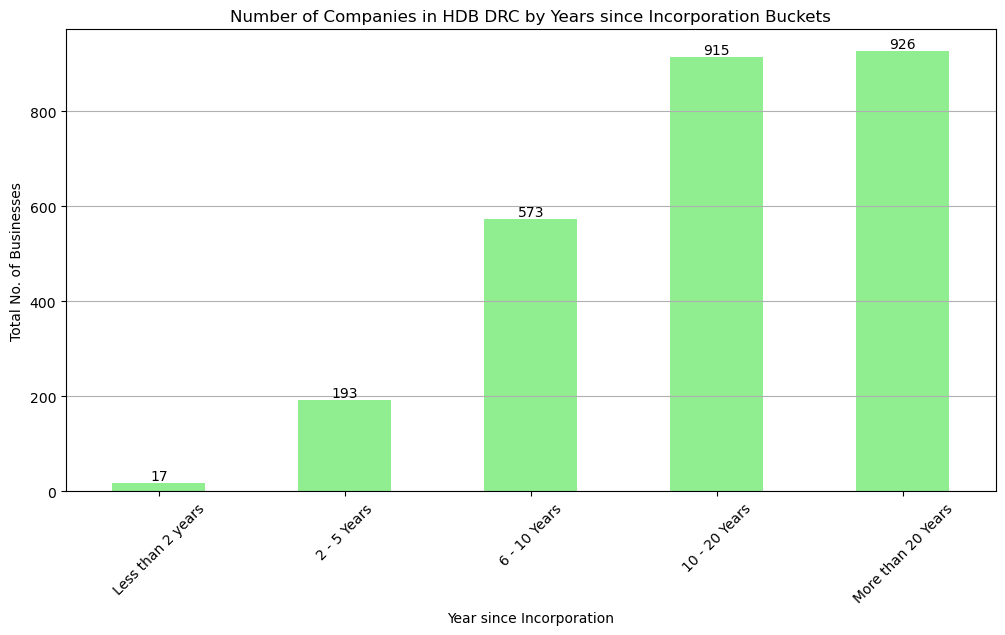

In [23]:
# Plotting the total counts for each year of incorporation
plt.figure(figsize=(12, 6))
ax = new_stacked_data['Total'].plot(kind='bar', color='lightgreen')
plt.title('Number of Companies in HDB DRC by Years since Incorporation Buckets')
plt.xlabel('Year since Incorporation')
plt.ylabel('Total No. of Businesses')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotating the bars with actual count
for i, count in enumerate(new_stacked_data['Total']):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()


# Workhead Distribution

In [24]:
distinct_workhead_type_cnt = hdb_3['bcawh_workhead_type'].fillna('No Workhead').value_counts()
print(distinct_workhead_type_cnt)

No Workhead                  1905
Construction-Related          638
Regulatory                    198
Construction                  182
Mechanical and Electrical     119
Trade Head                     17
Facilities Management          17
Supply Head                    10
Name: bcawh_workhead_type, dtype: int64


C:\Users\lim\AppData\Local\Temp\ipykernel_52556\2935075751.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bucketed_counts = distinct_workhead_type_cnt[distinct_workhead_type_cnt >= 100].append(pd.Series({'Others': others_count}))


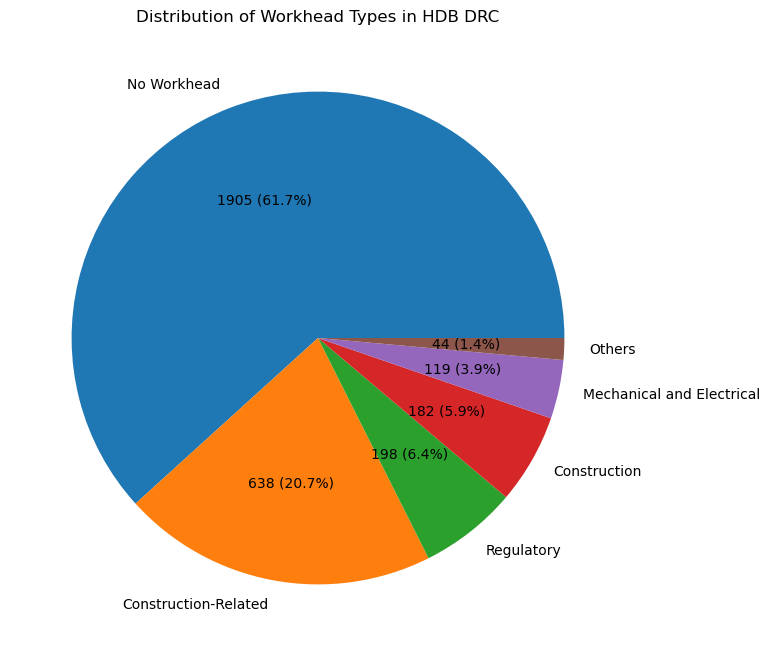

In [25]:
# Bucket counts less than 100 as "Others"
others_count = distinct_workhead_type_cnt[distinct_workhead_type_cnt < 100].sum()
bucketed_counts = distinct_workhead_type_cnt[distinct_workhead_type_cnt >= 100].append(pd.Series({'Others': others_count}))

# Calculate percentage
percentages = bucketed_counts / bucketed_counts.sum() * 100

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(bucketed_counts, labels=bucketed_counts.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(bucketed_counts) / 100, p))
plt.title('Distribution of Workhead Types in HDB DRC')
plt.show()

In [26]:
# Workhead Types / Workhead Sub-Types (Workhead Title)
hdb_3a = hdb_3
hdb_3a['bcawh_workhead_type'] = hdb_3a['bcawh_workhead_type'].fillna('No Workhead')
distinct_workhead_type_cnt_title = hdb_3a.groupby(['bcawh_workhead_type','bcawh_workhead_title']).size()

# Sort by Workhead_type and Count
whtype_order = ['Construction-Related', 'Regulatory','Construction','Mechanical and Electrical' ]
sorted_workhead_df = distinct_workhead_type_cnt_title.groupby(level='bcawh_workhead_type', group_keys=False).apply(lambda x: x.sort_values(ascending=False))
sorted_workhead_df_2 = sorted_workhead_df.reindex(whtype_order, level='bcawh_workhead_type')
print(sorted_workhead_df_2)

bcawh_workhead_type        bcawh_workhead_title                                 
Construction-Related       Interior Decoration & Finishing Works                    408
                           Repairs and Redecoration                                  49
                           Minor Construction Works                                  48
                           Demolition                                                44
                           Waterproofing Installation                                31
                           Doors                                                     14
                           Windows                                                   12
                           Curtain Walls                                             10
                           Signcraft Installation                                     8
                           Concrete Repairs                                           5
                           Fencing and 

In [27]:
# Workhead Types / Financial Grades
hdb_3b = hdb_3
hdb_3b['bcawh_workhead_type'] = hdb_3b['bcawh_workhead_type'].fillna('No Workhead')
workhead_grade = hdb_3a.groupby(['bcawh_workhead_type','bcawh_grade','bcawh_grade_financial_sgd',
                                                   'bcawh_track_record_sgd']).size()

whgrade_order = ['Construction-Related', 'Regulatory','Construction','Mechanical and Electrical' ]
sorted_df = workhead_grade.reindex(whgrade_order, level='bcawh_workhead_type')
sorted_df = sorted_df.rename_axis(index={'bcawh_workhead_type': 'Workhead Type',
                                         'bcawh_grade': 'Grade',
                                         'bcawh_grade_financial_sgd': 'Min. Net Worth',
                                         'bcawh_track_record_sgd': 'Min Project Track Record'})
print(sorted_df)

Workhead Type              Grade         Min. Net Worth  Min Project Track Record
Construction-Related       L1            10000.0         100000.0                    382
                           L2            50000.0         1000000.0                    47
                           L3            150000.0        3000000.0                    43
                           L4            250000.0        5000000.0                    26
                           L5            500000.0        10000000.0                   16
                           L6            1500000.0       30000000.0                    6
                           Single Grade  10000.0         100000.0                    118
Regulatory                 Single Grade  0.0             0.0                         198
Construction               A1            15000000.0      150000000.0                   2
                           B2            1000000.0       10000000.0                    9
                           C

In [28]:
# Group by 'hdb_company_name' and aggregate the maximum values for the specified columns
hdb_3c = hdb_3.groupby(['hdb_uen','hdb_company_name']).agg({
    'bcawh_grade_financial_sgd': 'max',
    'bcawh_track_record_sgd': 'max',
    'bcawh_paid_up_capital_sgd': 'max'
})

# Reset index to make 'hdb_company_name' a column again
hdb_3c.reset_index(inplace=True)

# Display the resulting DataFrame
print(hdb_3c[200:300])
print(hdb_3[hdb_3['hdb_uen']=='200501596E'])

        hdb_uen                        hdb_company_name  \
200  200204521Z       ATLANTIS INTERIOR PRIVATE LIMITED   
201  200204896G                 EMMA CONTRACT PTE. LTD.   
202  200206104C              HABITAT INTERIOR PTE. LTD.   
203  200206622W          KLEENERGY CONSTRUCTION PTE LTD   
204  200207072K        U-HOME INTERIOR DESIGN PTE. LTD.   
..          ...                                     ...   
295  200501596E       MIDAS ENVIRONMENT BUILDER PTE LTD   
296  200501731D          IMAGE ASSOCIATE DESIGN PTE LTD   
297  200502102E                    HAP DESIGN PTE. LTD.   
298  200502510N  SUNSHINE RENO & CONSTRUCTION PTE. LTD.   
299  200502589C              THE INTERIOR HOUSE PTE LTD   

     bcawh_grade_financial_sgd  bcawh_track_record_sgd  \
200                        NaN                     NaN   
201                    25000.0                100000.0   
202                        NaN                     NaN   
203                        NaN                     NaN   
2

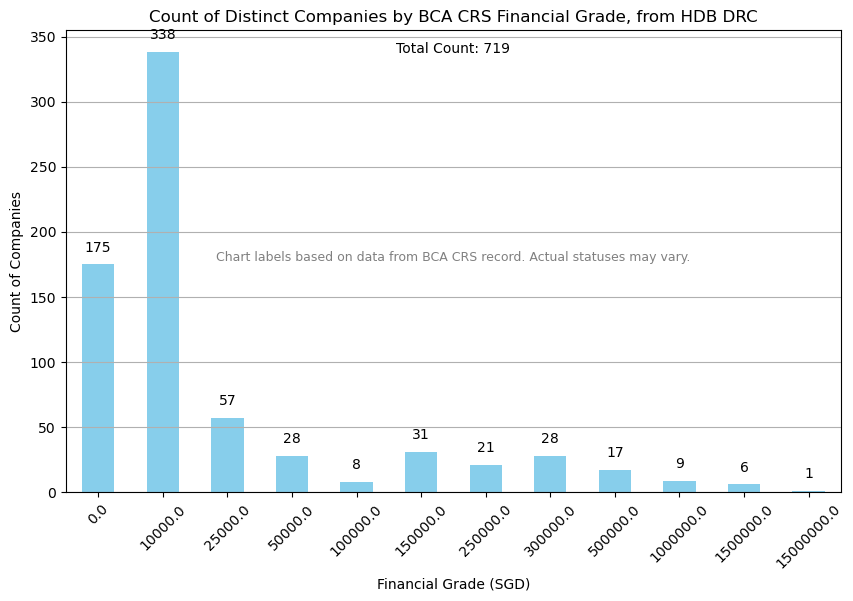

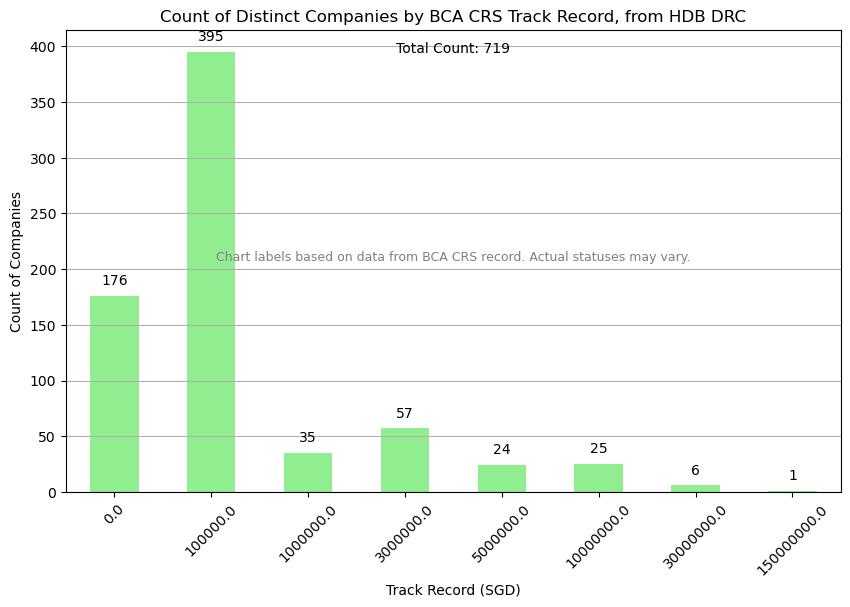

In [29]:
# Count the number of distinct companies for each value of bcawh_grade_financial_sgd
grade_financial_counts = hdb_3c['bcawh_grade_financial_sgd'].value_counts().sort_index()

# Count the number of distinct companies for each value of bcawh_track_record_sgd
track_record_counts = hdb_3c['bcawh_track_record_sgd'].value_counts().sort_index()

# Plotting the bar chart for bcawh_grade_financial_sgd
plt.figure(figsize=(10, 6))
ax = grade_financial_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Distinct Companies by BCA CRS Financial Grade, from HDB DRC')
plt.xlabel('Financial Grade (SGD)')
plt.ylabel('Count of Companies')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotate each bar with its count
for i, v in enumerate(grade_financial_counts):
    ax.text(i, v + 10, str(v), ha='center')

# Annotate the total count
total_count = grade_financial_counts.sum()
plt.text(0.5, 0.95, f'Total Count: {total_count}', transform=ax.transAxes, ha='center')
# Add disclaimer
plt.text(0.5, 0.5, 'Chart labels based on data from BCA CRS record. Actual statuses may vary.', transform=ax.transAxes, ha='center', fontsize=9, color='gray')
plt.show()

# Plotting the bar chart for bcawh_track_record_sgd
plt.figure(figsize=(10, 6))
ax = track_record_counts.plot(kind='bar', color='lightgreen')
plt.title('Count of Distinct Companies by BCA CRS Track Record, from HDB DRC')
plt.xlabel('Track Record (SGD)')
plt.ylabel('Count of Companies')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Annotate each bar with its count
for i, v in enumerate(track_record_counts):
    ax.text(i, v + 10, str(v), ha='center')

# Annotate the total count
total_count = track_record_counts.sum()
plt.text(0.5, 0.95, f'Total Count: {total_count}', transform=ax.transAxes, ha='center')
# Add disclaimer
plt.text(0.5, 0.5, 'Chart labels based on data from BCA CRS record. Actual statuses may vary.', transform=ax.transAxes, ha='center', fontsize=9, color='gray')
plt.show()

# SSIC Distribution

In [30]:
# Primary SSIC for all HDB Contractors
primary_ssic_description = hdb_2_new['acra_primary_ssic_description'].fillna('No SSIC Description').value_counts()
print(primary_ssic_description)

RENOVATION CONTRACTORS                                                                                                                     975
INTERIOR DESIGN SERVICES                                                                                                                   523
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)                                                                351
BUILDING CONSTRUCTION N.E.C.                                                                                                               253
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)                                                                       108
                                                                                                                                          ... 
REAL ESTATE ACTIVITIES ON A FEE OR COMMISSION BASIS N.E.C. (EXCLUDING ONLINE MARKETPLACES)                                                   1

In [31]:
# To bucket the SSIC
def auto_threshold(series_value_count, count_threshold, name_for_remaining):
    series_value_count_upper_dict = series_value_count[series_value_count>count_threshold].to_dict()
    series_value_count_upper_list = [x for x in series_value_count_upper_dict.keys()]
    series_value_count_lower_dict = series_value_count[series_value_count<=count_threshold].to_dict()
    series_value_count_lower_list = [x for x in series_value_count_lower_dict.keys()]
    series_value_count_lower_sum = series_value_count[series_value_count<=count_threshold].sum()
    
    new_series_dict = series_value_count_upper_dict
    new_series_dict[name_for_remaining] = series_value_count_lower_sum
    
    new_series = pd.Series(new_series_dict)
    return new_series, series_value_count_upper_list, series_value_count_lower_list

In [32]:
primary_ssic_description = hdb_2_new['acra_primary_ssic_description'].fillna('No SSIC Description').value_counts()
primary_ssic_series, primary_ssic_upper_list, primary_ssic_lower_list = auto_threshold(primary_ssic_description,20,'Others')
print(primary_ssic_series)
print(primary_ssic_upper_list)
print(primary_ssic_lower_list)

RENOVATION CONTRACTORS                                                         975
INTERIOR DESIGN SERVICES                                                       523
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)    351
BUILDING CONSTRUCTION N.E.C.                                                   253
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)           108
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)                                 85
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRAMES, GRILLES AND GRATINGS        65
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS                               23
Others                                                                         241
dtype: int64
['RENOVATION CONTRACTORS', 'INTERIOR DESIGN SERVICES', 'GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)', 'BUILDING CONSTRUCTION N.E.C.', 'MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)', 'G

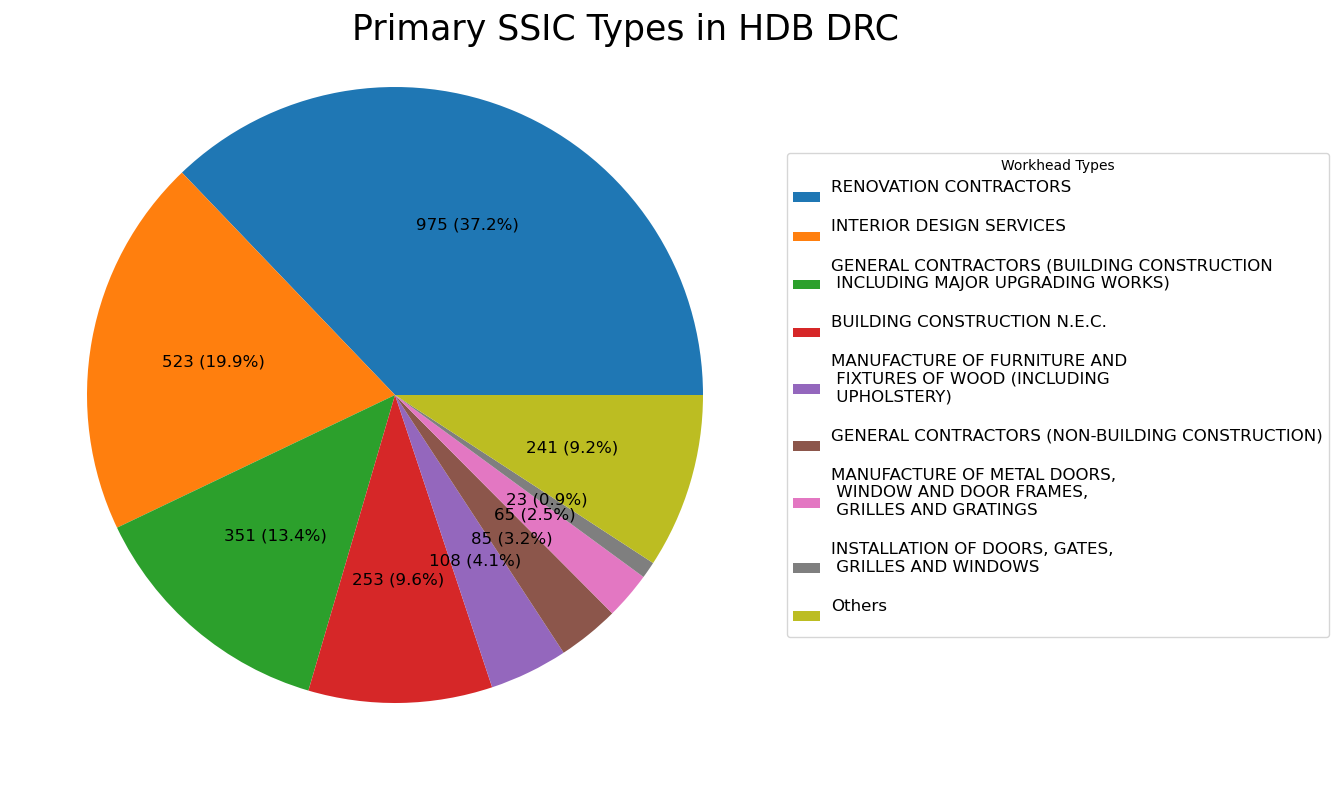

In [33]:
# Plot the pie chart

def insert_line_breaks(text, every_n_words=4):
    words = text.split()
    new_text = ' '.join(' '.join(words[i:i+every_n_words])+'\n' for i in range(0, len(words), every_n_words))
    return new_text

# Create a figure and plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(primary_ssic_series, labels=['' for _ in primary_ssic_series],
        autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(primary_ssic_series) / 100, p),
        textprops={'fontsize':12})
plt.title('Primary SSIC Types in HDB DRC', fontsize=25, y=0.95, x=0.8)  # Adjust y value here

# Create legend with labels and place it on the right-hand side
legend = plt.legend([insert_line_breaks(label) for label in primary_ssic_series.index], loc='center left', bbox_to_anchor=(1, 0.5), title="Workhead Types")
plt.setp(legend.get_texts(), fontsize='large')  # Set legend font size

plt.show()


# Year Bucket / Workhead

Less than 2 years      17
2 - 5 Years           193
6 - 10 Years          573
10 - 20 Years         915
More than 20 Years    926
Name: acra_years_bucket, dtype: int64


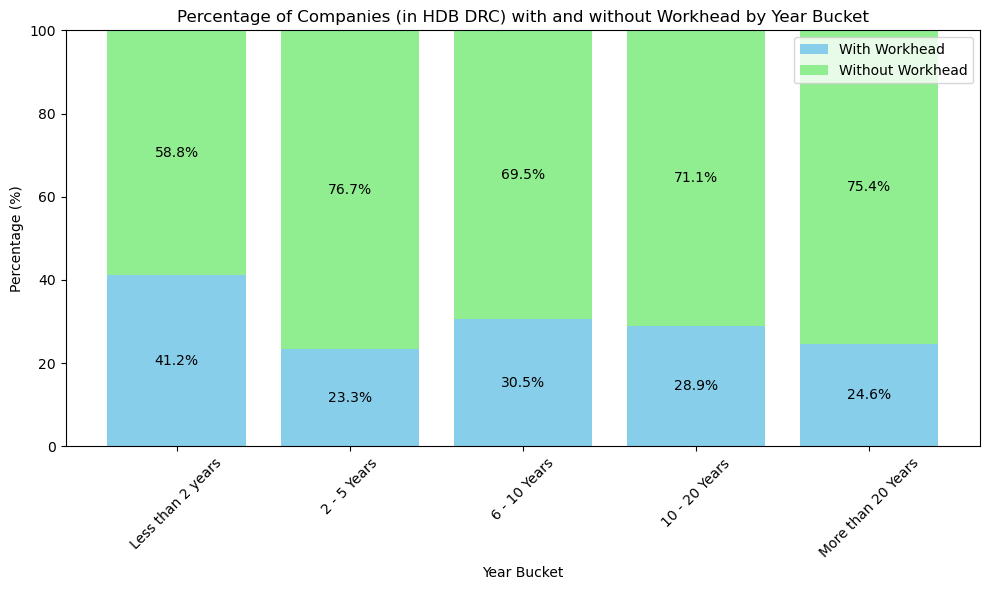

In [34]:
distinct_hdb_3 = hdb_3.drop_duplicates(subset='hdb_uen')
# Calculate the percentage of companies with and without workhead for each year bucket
year_bucket_counts = distinct_hdb_3['acra_years_bucket'].value_counts().sort_index()
print(year_bucket_counts)
workhead_present = distinct_hdb_3[distinct_hdb_3['bcawh_workhead'].notnull()]['acra_years_bucket'].value_counts().sort_index()
workhead_absent = year_bucket_counts - workhead_present

workhead_present_percentage = (workhead_present / year_bucket_counts) * 100
workhead_absent_percentage = (workhead_absent / year_bucket_counts) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))

plt.bar(workhead_present_percentage.index, workhead_present_percentage, label='With Workhead', color='skyblue')
plt.bar(workhead_absent_percentage.index, workhead_absent_percentage, bottom=workhead_present_percentage, label='Without Workhead', color='lightgreen')
# Annotating the percentages
for i, (wp, wa) in enumerate(zip(workhead_present_percentage, workhead_absent_percentage)):
    plt.text(i, wp / 2, f'{wp:.1f}%', ha='center', va='center', color='black')
    plt.text(i, wp + wa / 2, f'{wa:.1f}%', ha='center', va='center', color='black')
plt.title('Percentage of Companies (in HDB DRC) with and without Workhead by Year Bucket')
plt.xlabel('Year Bucket')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Workhead Title / Live / SSIC (bca / acra - non-hdb)
x-axis = ssic
y-axis = count of live
legend = workhead yes / no

In [35]:
# Join BCA / ACRA Info
# Create BCA distinct company name / uen (in CRS)
distinct_bca_uen_no = bca_2['bca_uen_no'].unique()

# If BCA uen in ACRA uen, col[workhead] = Yes, else = No
acra_df_1 = acra_df.copy()
acra_df_1['workhead_present'] = acra_df_1['acra_uen'].isin(distinct_bca_uen_no).map({True: 'Yes', False: 'No'})

# Filter by the Primary SSIC We want only.
# SSIC list from HDB DRC >= 20
pri_more_20 = ['RENOVATION CONTRACTORS', 'INTERIOR DESIGN SERVICES',
               'GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)',
               'BUILDING CONSTRUCTION N.E.C.',
               'MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)',
               'GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)',
               'MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRAMES, GRILLES AND GRATINGS',
               'INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS']
acra_df_1_filtered = acra_df_1[acra_df_1['acra_primary_ssic_description'].isin(pri_more_20)]
print(acra_df_1_filtered)

          acra_uen                          acra_entity_name acra_postal_code  \
449799   53251098D                           "D" FISHES TALK           520731   
436832  201201191G             "K"LINE ENGINEERING PTE. LTD.           522872   
444834   52873209M  "R" DESIGN RENOVATE & CONSTRUCT SERVICES           534868   
444268   51941700C                            #02-02 TRADING           190465   
440368  201925566H                #1 DESIGN STUDIO PTE. LTD.           409535   
...            ...                                       ...              ...   
81920   202232468E                  ZZ PERSPECTIVE PTE. LTD.           038987   
87137    53090882D              ZZ TOP INTERIOR AND SERVICES           419737   
82663   202346791W        ZZF PERIMETER PROTECTION PTE. LTD.           208577   
84536    52799605W                  ZZL SCI-TECH (SINGAPORE)           079903   
85459    52906975W                ZZS CONSTRUCTION & TRADING           588179   

       acra_entity_type_des

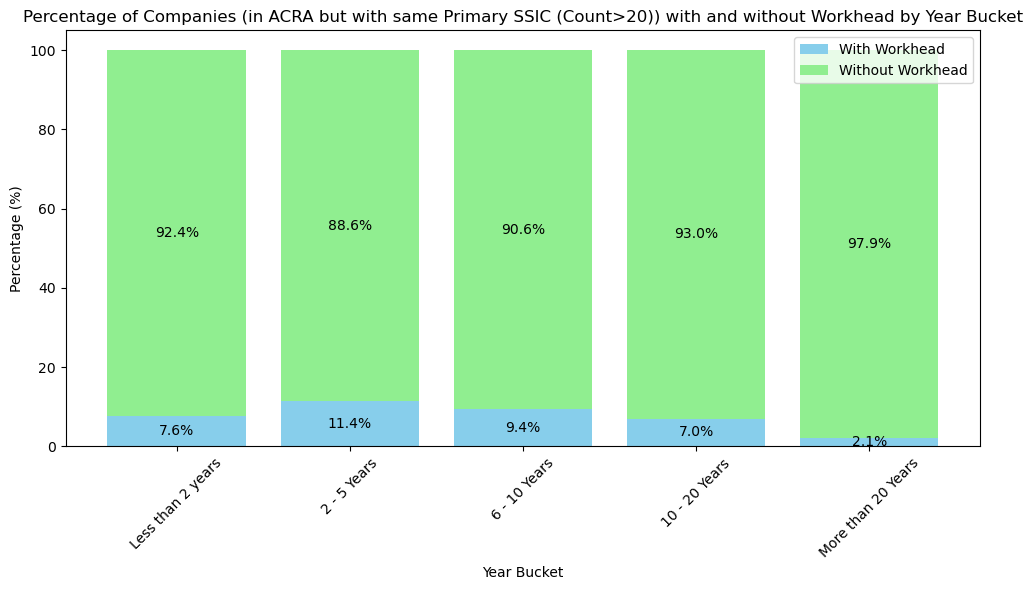

In [36]:
# Calculate the percentage of companies with and without a workhead for each year bucket
year_bucket_counts = acra_df_1_filtered['acra_years_bucket'].value_counts().sort_index()
workhead_present_counts = acra_df_1_filtered[acra_df_1_filtered['workhead_present'] == 'Yes']['acra_years_bucket'].value_counts().sort_index()
workhead_absent_counts = acra_df_1_filtered[acra_df_1_filtered['workhead_present'] == 'No']['acra_years_bucket'].value_counts().sort_index()

# Calculate the percentages
workhead_present_percentage = (workhead_present_counts / year_bucket_counts) * 100
workhead_absent_percentage = (workhead_absent_counts / year_bucket_counts) * 100

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
plt.bar(workhead_present_percentage.index, workhead_present_percentage, label='With Workhead', color='skyblue')
plt.bar(workhead_absent_percentage.index, workhead_absent_percentage, bottom=workhead_present_percentage, label='Without Workhead', color='lightgreen')
# Annotating the percentages
for i, (wp, wa) in enumerate(zip(workhead_present_percentage, workhead_absent_percentage)):
    plt.text(i, wp / 2, f'{wp:.1f}%', ha='center', va='center', color='black')
    plt.text(i, wp + wa / 2, f'{wa:.1f}%', ha='center', va='center', color='black')
# Add labels and title
plt.title('Percentage of Companies (in ACRA but with same Primary SSIC (Count>20)) with and without Workhead by Year Bucket')
plt.xlabel('Year Bucket')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
